
# Section 3 — Hybrid Retrieval Strategy (sparse + dense)

Le **retrieval hybride** combine le meilleur des deux mondes :
- **Sparse** (lexical) : sensibilité au *recouvrement exact* des termes — BoW/TF‑IDF/BM25.
- **Dense** (sémantique) : capture le **sens** et les **paraphrases** via des **embeddings**.

But : **améliorer la pertinence** en fusionnant les signaux.  
Nous allons :
1. Construire un index **sparse** (TF‑IDF, avec option BM25 mini).
2. Générer des **embeddings de phrases** avec un modèle **Hugging Face** (Sentence-Transformers).
3. Récupérer les *Top‑N* candidats dans chaque espace.
4. **Fusionner** (somme pondérée après normalisation, **RRF** — *Reciprocal Rank Fusion*).
5. Visualiser l'effet de la fusion.



## Pré-requis (installation)
Exécutez **une seule fois** si nécessaire (commenté par défaut) :


In [ ]:

# %pip -q install --upgrade pip
# %pip -q install scikit-learn sentence-transformers torch --extra-index-url https://download.pytorch.org/whl/cpu



## Données d'exemple
On réutilise un mini-corpus multi-lingue et quelques requêtes pour observer les différences entre sparse, dense et hybride.


In [2]:

from typing import List, Tuple, Dict
import numpy as np

corpus = [
    # --- Concepts généraux & définitions ---
    "La recherche d'information (IR) vise à retrouver des documents pertinents pour un besoin utilisateur exprimé sous forme de requête.",
    "Un pipeline RI comporte souvent : prétraitement, indexation, pondération, scoring, puis évaluation des résultats.",
    "Le modèle sac de mots ignore l'ordre des termes et représente un document par la fréquence des mots.",
    "TF-IDF pondère fort les mots fréquents dans un document mais rares dans le corpus ; TF peut être brut, log-normalisé ou binaire.",
    "Okapi BM25 est un schéma de ranking basé sur la saturation de fréquence et la normalisation par longueur de document.",
    "BM25+ et BM25L sont des variantes qui ajustent la normalisation de longueur et l'offset des faibles fréquences.",
    "Les embeddings denses encodent le sens dans un espace vectoriel continu, utiles pour la recherche sémantique.",
    "La recherche vectorielle peut être clairsemée (sparse) ou dense selon la représentation.",
    "RAG (Retrieval-Augmented Generation) combine récupération de passages et modèles génératifs pour produire des réponses sourcées.",
    "La pertinence peut être binaire ou graduée (gains), ce qui change la métrique optimale.",

    # --- Prétraitement & normalisation ---
    "La normalisation inclut les accents, la casse, la tokenisation, le stemming et la lemmatisation.",
    "Les mots vides (stopwords) comme 'le', 'la', 'de' sont souvent supprimés pour réduire le bruit.",
    "La lemmatisation française nécessite de gérer les accords et les formes verbales composées.",
    "Le stemming de Porter tronque les suffixes, au risque d'ambiguïtés (ex. 'nation' et 'national').",
    "Les fautes de frappe et variantes orthographiques (ex. 'recherhe', 'recherche') pénalisent les méthodes exactes.",
    "Les entités nommées (NER) aident à conserver des unités sémantiques comme 'OpenAI' ou 'Europe/Paris'.",

    # --- Outils & bibliothèques ---
    "Scikit-learn fournit CountVectorizer et TfidfVectorizer pour les représentations clairsemées.",
    "Gensim facilite le topic modeling (LDA) et des pipelines BoW/TF-IDF rapides.",
    "FAISS, HNSW (hnswlib), Annoy et ScaNN accélèrent la recherche de plus proches voisins approximatifs (ANN).",
    "Sentence-BERT (SBERT), E5, MPNet et ColBERT sont populaires pour l'indexation dense ou late interaction.",
    "Elasticsearch et OpenSearch implémentent BM25 par défaut et supportent la recherche hybride sparse+dense.",

    # --- Évaluation ---
    "L'évaluation compare précision, rappel, F1, MAP, MRR, nDCG@k et taux de couverture des passages.",
    "MRR mesure l'inverse du rang de la première réponse correcte ; nDCG mesure des gains gradués.",
    "Les jeux de données TREC, MS MARCO et BEIR sont des bancs d'essai courants.",
    "La validation croisée et le split train/dev/test évitent le surapprentissage sur le corpus d'évaluation.",
    "Le jugement de pertinence peut être humain, heuristique ou obtenu via pooling multi-systèmes.",

    # --- Multilingue & domaines ---
    "Les requêtes peuvent être multilingues ; les modèles multilingues mappent plusieurs langues dans le même espace.",
    "Dans le domaine médical, la précision terminologique est cruciale (ex. 'hypertension artérielle').",
    "En droit, les synonymes et références croisées (articles, alinéas) créent de la variance lexicale.",
    "Les recettes de cuisine génèrent des listes d'ingrédients qui favorisent la pondération TF simple.",
    "La recherche académique bénéficie d'expressions multi-mots comme 'régression logistique' ou 'réseau de neurones'.",

    # --- Bruit, longueur et structure ---
    "Certains documents sont très courts: 'BM25 expliqué rapidement'.",
    "D'autres sont longs et contiennent des sections, des listes, des liens et des tableaux qui influencent la tokenisation.",
    "URLs et hashtags (#IR, #NLP) perturbent parfois la segmentation en tokens.",
    "Les citations de code `pip install faiss-gpu` ou `from sklearn.feature_extraction.text import TfidfVectorizer` doivent être préservées.",

    # --- Recherche hybride & reranking ---
    "La recherche hybride combine BM25 pour l'exact match et embeddings denses pour la similarité sémantique.",
    "Le reranking par un cross-encoder (ex. monoT5, cross-encoder-MiniLM) affine les top-k candidats.",
    "La réduction de dimension (PCA) ou la quantification des vecteurs (PQ, IVFPQ) accélère l'ANN au prix d'une légère perte de rappel.",
    "Le champ 'title' a souvent plus de poids que 'body' dans les moteurs de recherche.",
    "La désambiguïsation des acronymes (ex. 'IR' = 'information retrieval' ou 'imagerie par résonance') dépend du contexte.",

    # --- Cas concrets & exemples mixtes ---
    "Le sac de mots (bag of words) est simple et robuste mais ne capture pas la sémantique profonde.",
    "TF–IDF (avec tiret demi-cadratin) est équivalent à TF-IDF (avec tiret standard) pour la plupart des implémentations.",
    "Okapi-BM25 et bm25 ranking désignent la même famille de fonctions de scoring.",
    "Une requête négative comme 'BM25 sans normalisation de longueur' nécessite des opérateurs booléens.",
    "La recherche de vecteurs denses peut tolérer les fautes: 'embeding denses' correspond souvent à 'embeddings denses'.",
    "Vector search peut être sparse or dense depending on the representation (mélange FR/EN).",
    "L'alignement d'espaces multilingues permet 'apprentissage' ≈ 'learning' ≈ 'aprendizaje'.",
    "Les paramètres clés de BM25 sont k1 et b ; k1 contrôle la saturation, b la normalisation de longueur.",
    "Le choix des stop words en français diffère de l'anglais (ex. 'au', 'aux', 'des', 'du').",
    "Le pré-traitement influence fortement les résultats, surtout avec de petites requêtes.",
    "La normalisation Unicode (NFC/NFKD) affecte le traitement des diacritiques (é/ê/e).",
    "En RAG, l'ordre : retrieve → read → generate ; la qualité du retrieve détermine souvent 80% du succès perçu.",
    "Une indexation incrémentale maintient la fraîcheur des résultats sans reconstruire tout l'index."
]

queries = [
    # Requêtes ciblées IR
    "comment fonctionne BM25 (k1, b) pour le ranking ?",
    "différence entre sac de mots et TF-IDF",
    "CountVectorizer vs TfidfVectorizer scikit-learn",
    "bm25 ranking vs dense retrieval",
    "quels avantages des embeddings denses pour la sémantique ?",

    # Prétraitement & robustesse
    "liste de stopwords en français et impact sur la précision",
    "lemmatisation vs stemming pour le français",
    "normalisation des accents et diacritiques",
    "gerer les fautes de frappe en recherche d'information",
    "traiter les hashtags et urls dans les documents",

    # Évaluation
    "comparer MAP, MRR et nDCG@10",
    "datasets d'évaluation: TREC, MS MARCO, BEIR",
    "pooling et jugement de pertinence gradué",
    "quelle métrique pour la pertinence multi-niveaux ?",

    # Multilingue & domaines
    "recherche multilingue avec SBERT ou E5",
    "RAG pour questions médicales",
    "désambiguïser l'acronyme IR selon le contexte",
    "recherche juridique: articles et alinéas",
    "recettes: pondération TF simple vs BM25",

    # ANN & systèmes
    "HNSW vs FAISS vs Annoy pour ANN",
    "hybrid search: combiner BM25 et embeddings",
    "cross-encoder pour reranking des top-k",
    "quantification des vecteurs (IVFPQ) et rappels",
    "pondérer le champ title plus que body",

    # Requêtes bruitées / mixtes / typos
    "tf–idf (variante typographique) explication",
    "embeding denses (typo) utilité",
    "Okapi-BM25 formule",
    "vector search sparse or dense",
    "BM25 sans normalisation de longueur"
]
doc_ids_all = np.arange(len(corpus))
print(f"Corpus: {len(corpus)} documents | Ex. requêtes: {queries[:3]} ...")


Corpus: 53 documents | Ex. requêtes: ['comment fonctionne BM25 (k1, b) pour le ranking ?', 'différence entre sac de mots et TF-IDF', 'CountVectorizer vs TfidfVectorizer scikit-learn'] ...



## 1) Composant **Sparse**
Nous utilisons **TF‑IDF** (scikit-learn) pour la base, et proposons en option une implémentation **BM25** compacte.  
On calcule la **similarité cosinus** entre la requête vectorisée et les documents.


In [3]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import math
from collections import Counter

# --- TF-IDF ---
tfidf_vec = TfidfVectorizer(lowercase=True)
X_tfidf = tfidf_vec.fit_transform(corpus)

def search_tfidf(query: str) -> np.ndarray:
    q = tfidf_vec.transform([query])
    return cosine_similarity(q, X_tfidf).ravel()

# --- BM25 mini (optionnel) ---
class BM25OkapiMini:
    def __init__(self, docs: List[str], tokenizer=str.split, k1: float = 1.5, b: float = 0.75):
        self.k1, self.b = k1, b
        self.tokenizer = tokenizer
        self.tokens = [tokenizer(d.lower()) for d in docs]
        self.tf = [Counter(toks) for toks in self.tokens]
        self.doc_lens = [len(toks) for toks in self.tokens]
        self.avgdl = sum(self.doc_lens) / len(self.doc_lens)
        self.N = len(docs)
        # df + idf
        df = Counter()
        for c in self.tf:
            for t in c: df[t] += 1
        self.idf = {t: math.log((self.N - df_t + 0.5) / (df_t + 0.5) + 1) for t, df_t in df.items()}
    def score(self, query: str) -> np.ndarray:
        q_terms = self.tokenizer(query.lower())
        scores = np.zeros(self.N, dtype=float)
        for i, c in enumerate(self.tf):
            denom_norm = self.k1 * (1 - self.b + self.b * self.doc_lens[i] / self.avgdl)
            s = 0.0
            for t in q_terms:
                if t not in c: continue
                tf_td = c[t]
                idf_t = self.idf.get(t, 0.0)
                s += idf_t * ((tf_td * (self.k1 + 1)) / (tf_td + denom_norm))
            scores[i] = s
        return scores

bm25 = BM25OkapiMini(corpus)

def search_bm25(query: str) -> np.ndarray:
    return bm25.score(query)

def sparse_search(query: str, method: str = "tfidf") -> np.ndarray:
    if method == "bm25":
        return search_bm25(query)
    return search_tfidf(query)



## 2) Composant **Dense** (Hugging Face — Sentence-Transformers)

On choisit un modèle **multilingue** pour encoder les documents et les requêtes :  
`sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2` (rapide et efficace).  
On **normalise** les embeddings pour que le produit interne équivaille au **cosinus**.


In [4]:

# %pip -q install sentence-transformers
from sentence_transformers import SentenceTransformer

ST_MODEL_NAME = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
st_model = SentenceTransformer(ST_MODEL_NAME)
doc_vecs_dense = st_model.encode(corpus, convert_to_numpy=True, normalize_embeddings=True)

def dense_search(query: str) -> np.ndarray:
    q = st_model.encode([query], convert_to_numpy=True, normalize_embeddings=True)[0]
    return doc_vecs_dense @ q  # cosinus (car normalisé)


c:\Users\salah\anaconda3\envs\ragllm\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\salah\anaconda3\envs\ragllm\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\salah\.cache\huggingface\hub\models--sentence-transformers--paraphrase-multilingual-MiniLM-L12-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an 


## 3) Stratégies de **Fusion**
Deux recettes simples et efficaces :

- **Somme pondérée** après **normalisation** des scores  :  


- **RRF — Reciprocal Rank Fusion** : combine des **rangs** plutôt que des scores, robuste aux échelles différentes :  

  avec un **k** typiquement 60 (valeur classique).

> En pratique : on **restreint** la fusion à l'union des *Top‑N* candidats de chaque méthode (ex. N=8 ou 50).


In [5]:

def minmax_norm(x: np.ndarray) -> np.ndarray:
    lo, hi = float(np.min(x)), float(np.max(x))
    if hi - lo < 1e-12:
        return np.zeros_like(x)  # tous égaux
    return (x - lo) / (hi - lo)

def weighted_sum_fusion(scores_sparse: np.ndarray, scores_dense: np.ndarray, alpha: float = 0.5) -> np.ndarray:
    s_sp = minmax_norm(scores_sparse)
    s_de = minmax_norm(scores_dense)
    return alpha * s_sp + (1 - alpha) * s_de

def rrf_fusion(scores_list: List[np.ndarray], k: int = 60) -> np.ndarray:
    # Convertit des scores → rangs (ordre décroissant)
    n = scores_list[0].shape[0]
    rrf = np.zeros(n, dtype=float)
    for scores in scores_list:
        ranks = np.argsort(np.argsort(-scores))  # rang 0 = meilleur
        # RRF additionne 1 / (k + rank)
        rrf += 1.0 / (k + ranks.astype(float))
    return rrf

def topn_union(scores: np.ndarray, n: int) -> set:
    idx = np.argsort(scores)[::-1][:n]
    return set(idx.tolist())

def hybrid_search(query: str, sparse_method="tfidf", top_n_each: int = 8, alpha: float = 0.5, k_rrf: int = 60) -> dict:
    # 1) Scores bruts
    sp = sparse_search(query, method=sparse_method)
    de = dense_search(query)
    # 2) Restreindre à l'union des top-N
    cand = sorted(list(topn_union(sp, top_n_each) | topn_union(de, top_n_each)))
    # 3) Préparer des vecteurs "candidats only"
    mask = np.zeros_like(sp, dtype=bool); mask[cand] = True
    sp_c = np.where(mask, sp, np.min(sp) - 1.0)  # pour garder les tailles constantes
    de_c = np.where(mask, de, np.min(de) - 1.0)
    # 4) Fusions
    fused_ws = weighted_sum_fusion(sp_c, de_c, alpha=alpha)
    fused_rrf = rrf_fusion([sp_c, de_c], k=k_rrf)
    return {
        "sparse_scores": sp,
        "dense_scores": de,
        "candidates": cand,
        "weighted_sum": fused_ws,
        "rrf": fused_rrf
    }

def show_ranking(title: str, scores: np.ndarray, k: int = 5):
    order = np.argsort(scores)[::-1][:k]
    print(f"\n{title}")
    print("-" * 80)
    for r, i in enumerate(order, 1):
        print(f"[{r:>2}] score={scores[i]:.4f}  doc#{i} → {corpus[i]}")



## 4) Démo : de bout en bout
Pour chaque requête :
1. Top‑N **sparse** (TF‑IDF par défaut).
2. Top‑N **dense** (Sentence-Transformers).
3. **Fusion** par somme pondérée (α=0.5) et **RRF** (k=60).


In [6]:

TOP_N = 8  # candidats par canal
ALPHA = 0.5
K_RRF = 60
SPARSE_METHOD = "tfidf"  # "tfidf" ou "bm25"

for q in queries:
    res = hybrid_search(q, sparse_method=SPARSE_METHOD, top_n_each=TOP_N, alpha=ALPHA, k_rrf=K_RRF)
    # Affichage
    show_ranking(f"Query: {q!r} — Sparse ({SPARSE_METHOD})", res["sparse_scores"], k=5)
    show_ranking(f"Query: {q!r} — Dense (Sentence-Transformers)", res["dense_scores"], k=5)
    show_ranking(f"Query: {q!r} — Hybride (Somme pondérée, α={ALPHA})", res["weighted_sum"], k=5)
    show_ranking(f"Query: {q!r} — Hybride (RRF, k={K_RRF})", res["rrf"], k=5)



Query: 'comment fonctionne BM25 (k1, b) pour le ranking ?' — Sparse (tfidf)
--------------------------------------------------------------------------------
[ 1] score=0.4227  doc#47 → Les paramètres clés de BM25 sont k1 et b ; k1 contrôle la saturation, b la normalisation de longueur.
[ 2] score=0.3281  doc#42 → Okapi-BM25 et bm25 ranking désignent la même famille de fonctions de scoring.
[ 3] score=0.2362  doc#35 → La recherche hybride combine BM25 pour l'exact match et embeddings denses pour la similarité sémantique.
[ 4] score=0.2105  doc#4 → Okapi BM25 est un schéma de ranking basé sur la saturation de fréquence et la normalisation par longueur de document.
[ 5] score=0.1755  doc#11 → Les mots vides (stopwords) comme 'le', 'la', 'de' sont souvent supprimés pour réduire le bruit.

Query: 'comment fonctionne BM25 (k1, b) pour le ranking ?' — Dense (Sentence-Transformers)
--------------------------------------------------------------------------------
[ 1] score=0.7573  doc#47 → Les


## 5) Visualisation rapide (facultatif)
Pour une requête, on compare les **scores normalisés** de chaque canal et la **fusion**.


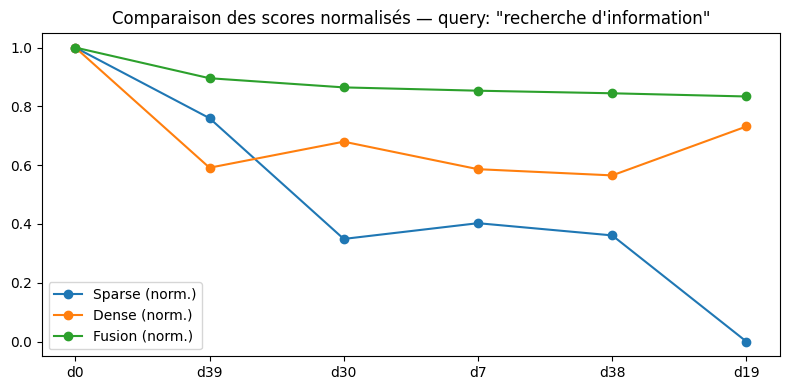

In [7]:

import numpy as np
import matplotlib.pyplot as plt

query = "recherche d'information"
res = hybrid_search(query, sparse_method="tfidf", top_n_each=8, alpha=0.5, k_rrf=60)

# On affiche les 6 meilleurs documents selon la somme pondérée
order = np.argsort(res["weighted_sum"])[::-1][:6]
labels = [f"d{i}" for i in order]
s_sp = (res["sparse_scores"] - res["sparse_scores"].min()) / (res["sparse_scores"].ptp() + 1e-12)
s_de = (res["dense_scores"] - res["dense_scores"].min()) / (res["dense_scores"].ptp() + 1e-12)
s_ws = (res["weighted_sum"] - res["weighted_sum"].min()) / (res["weighted_sum"].ptp() + 1e-12)

x = np.arange(len(order))
plt.figure(figsize=(8,4))
plt.plot(x, s_sp[order], marker="o", label="Sparse (norm.)")
plt.plot(x, s_de[order], marker="o", label="Dense (norm.)")
plt.plot(x, s_ws[order], marker="o", label="Fusion (norm.)")
plt.xticks(x, labels)
plt.title(f"Comparaison des scores normalisés — query: {query!r}")
plt.legend(loc="best")
plt.tight_layout()
plt.show()
